In [282]:
import numpy as np
import numpy_financial as npf 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [283]:
# Variables

# universal variables
income = 100000 
married = False
inflation_exp = 0.03
time_horizon = 5     # years until planning to move

In [284]:



# rental variables
current_rent = 3500
rent_incr_exp = 0.03      # ***updated with maximum CA rent increase law
renter_ins = 0.01         # estimated percentage of rent
sec_deposit = 0.2        # estimated percentage of rent
invest_yield_exp = 0.05   # expected annual yield on investments made with money saved from not buying a home


# purchase variables
home_price = 500000
down_pmt = 0.0          # percent of home price
int_rate = 0.05
term = 30

hoa = 0        #monthly mount
prop_tax = 0.012       # annualized percentage of assessed home value
home_ins = 0.002          # annualized percentage of home price
home_repairs = 0.01       # annualized estimate of repairs & improvements as percentage of home price

loan_type_options = ['Conventional', 'VA', 'FHA', 'USDA']    # ***can we create a drop-down menu with 'Conventional', 'VA', 'FHA', and 'USDA'?
loan_type = loan_type_options[0] 

fees_out_of_pocket = False   # will VA funding fee or intitial PMI costs be paid out of pocket, as opposed to rolled into loan
VA_ff = True             # does VA funding fee apply or are they waived (service-disabled)

closing_cost = 0.03           # applied to both sale and purchase
realtor_fee = 0.06            # assumed to apply at sale, not purchase

price_appr_exp = 0.03       # expectations on avg annual home price appreciation

#rent_after_move = True        # ***maybe add some calc options for NPV of rental income if not selling home after time horizon



In [285]:
# functions & calculations

def tax_rate(married, income, capital_gains):
    single_brackets = {
        11600: 0.10,
        47150: 0.12,
        100525: 0.22,
        191950: 0.24,
        243725: 0.32,
        609350: 0.35,
        float('inf'): 0.37 
        }
    married_brackets = {
        23200: 0.10,
        94300: 0.12,
        201050: 0.22,
        383900: 0.24,
        487450: 0.32,
        731200: 0.35,
        float('inf'): 0.37
        }
    brackets = married_brackets if married else single_brackets
    for key in brackets.keys():
        if income > key:
            continue
        else:
            income_tax_rate = brackets[key]
    
    combined_income = income + capital_gains
    single_capgain = {
        47025: 0.0,    
        518900: 0.15, 
        float('inf'): 0.20  
        }
    married_capgain = {
        94050: 0.0,    
        583750: 0.15,  
        float('inf'): 0.20
        }
    capgain = married_capgain if married else single_capgain
    for key in capgain.keys():
        if combined_income > key:
            continue
        else:
            capital_gains_rate = capgain[key]

    return income_tax_rate, capital_gains_rate


sec_deposit = current_rent * sec_deposit

def annual_rental_cost(yrs_rented):
    adj_rent = 12 * (current_rent * ((1 + rent_incr_exp) ** yrs_rented))
    adj_total = adj_rent + (adj_rent * renter_ins)
    adj_total += sec_deposit if yrs_rented == 0 else 0
    return adj_total

def gross_rental_cost(yrs_rented):
    result = sec_deposit
    for i in range(yrs_rented):
        adj_rent = 12 * (current_rent * ((1 + rent_incr_exp) ** i))
        adj_total = adj_rent + (adj_rent * renter_ins)
        result += adj_total
    return result

# calculate loan amount and applicable mortgage insurance or va funding fee amounts
dp = home_price * down_pmt
loan_amt = home_price - dp

init_mort_ins = 0
mo_mort_ins = 0
init_va_ff = 0
USDA_fee = 0

if loan_type == 'Conventional' and down_pmt < 0.2:
    mo_mort_ins = loan_amt * 0.01 / 12  #estimate, maybe more precision here?
elif loan_type == 'VA' and VA_ff == True:
    if down_pmt < 0.05:
        init_va_ff = loan_amt * 0.0215
    elif down_pmt < 0.1:
        init_va_ff = loan_amt * 0.015
    else:
        init_va_ff = loan_amt * 0.0125
elif loan_type == 'FHA':
    init_mort_ins = loan_amt * 0.0175
    mo_mort_ins = loan_amt * 0.0085 / 12
elif loan_type == 'USDA':
    init_mort_ins = loan_amt * 0.01
    USDA_fee = 0.0035 / 12

loan_amt += ((init_va_ff + init_mort_ins) if not fees_out_of_pocket else 0)

def initial_payment():
    cc = home_price * closing_cost
    return dp + cc + ((init_va_ff + init_mort_ins) if fees_out_of_pocket else 0)

def annual_payments(yrs_owned):
    mo_PI = npf.pmt(
            int_rate / 12, 
            term * 12, 
            -loan_amt
        ) if yrs_owned < term + 1 else 0

    assd_incr_actual = min(0.02, inflation_exp)   # avg annual assessed value increase (for prop tax) - capped at 2% in CA
    mo_tax = (prop_tax / 12) * (home_price * ((1 + assd_incr_actual) ** yrs_owned))

    mo_ins = (home_ins / 12) * (home_price * ((1 + inflation_exp) ** yrs_owned))
    mo_repairs = (home_repairs / 12) * (home_price * ((1 + inflation_exp) ** yrs_owned))
    mo_hoa = hoa * ((1 + inflation_exp) ** yrs_owned)

    remaining_principal = npf.fv(
        int_rate / 12, 
        yrs_owned * 12, 
        mo_PI, 
        -loan_amt
    )
    mo_USDA_fee = USDA_fee * remaining_principal

    tot_mo_cost = (mo_PI + 
                   mo_tax + 
                   mo_ins + 
                   mo_repairs + 
                   mo_hoa + 
                   mo_mort_ins + 
                   mo_USDA_fee
                   )

    return 12 * tot_mo_cost

def annual_ownership_cost(yrs_owned):
    tot_init_cost = initial_payment()
    return annual_payments(yrs_owned) + (tot_init_cost if yrs_owned == 0 else 0)

def gross_ownership_cost(yrs_owned):    
    tot_init_cost = initial_payment()
    result = tot_init_cost
    for i in range(yrs_owned):
        result += annual_payments(i)
    return result

def home_sale_proceeds(yrs_owned):
    estimate_sale_price = home_price * ((1 + price_appr_exp) ** yrs_owned)
    
    scc = estimate_sale_price * closing_cost
    srf = estimate_sale_price * realtor_fee
    improvements =  0.50 * npf.fv(inflation_exp / 12, 
                                  yrs_owned * 12, 
                                  -home_price * home_repairs / 12, 
                                  0
                                  )
    cap_gains = estimate_sale_price - home_price - scc - srf - improvements

    income_tax_rate, capital_gains_rate = tax_rate(married, income, cap_gains)

    if yrs_owned < 1:
        cap_gains_tax = cap_gains * income_tax_rate
    elif yrs_owned < 2:
        cap_gains_tax = cap_gains * capital_gains_rate
    else:
        cap_gains_tax = (cap_gains - (250_000 * (married + 1))) * capital_gains_rate

    cap_gains_tax = max(cap_gains_tax, 0)

    mo_PI = npf.pmt(
            int_rate / 12, 
            term * 12, 
            -loan_amt
        )

    remaining_principal = npf.fv(
        int_rate / 12, 
        yrs_owned * 12, 
        mo_PI, 
        -loan_amt
    )

    result = estimate_sale_price - scc - srf - remaining_principal - cap_gains_tax
    return result, estimate_sale_price, improvements

def net_ownership_cost(yrs_owned):
    return gross_ownership_cost(yrs_owned) - home_sale_proceeds(yrs_owned)[0]


In [286]:
# calculate total cost values for given time horizon
gr_rent = gross_rental_cost(time_horizon)
gr_own = gross_ownership_cost(time_horizon)
net_own = net_ownership_cost(time_horizon)
sale_profit = home_sale_proceeds(time_horizon)[0]
sale_price = home_sale_proceeds(time_horizon)[1]


# convert data to time-series dataframes for plotting
ub = time_horizon + 10 if time_horizon > 5 else time_horizon + 5
years = np.arange(0, ub)
cum_rent = [gross_rental_cost(yr) for yr in years]
cum_gross_own = [gross_ownership_cost(yr) for yr in years]
cum_net_own = [net_ownership_cost(yr) for yr in years]
ann_rent = np.array([annual_rental_cost(yr) for yr in years])
ann_own = np.array([annual_ownership_cost(yr) for yr in years])

# establish annual costs and account for opportunity cost of investing extra cash from renting
ann_df = pd.DataFrame({
    'Annual Rental Cost': ann_rent,
    'Annual Ownership Cost': ann_own,
    'Extra Cash From Renting': ann_own - ann_rent
    }, index=years
)
ann_df['Cumulative Delta'] = ann_df['Extra Cash From Renting'].cumsum()
ann_df['Cumulative Invested Returns'] = ann_df['Extra Cash From Renting'].expanding().apply(
        lambda x: sum([v * (1 + invest_yield_exp) ** (len(x) - i - 1) for i, v in enumerate(x)])) - ann_df['Cumulative Delta']

# establish cumulative gross & net costs
cum_df = pd.DataFrame({
    'Cumulative Gross Rental Cost': cum_rent,
    'Cumulative Net Rental Cost': cum_rent - ann_df['Cumulative Invested Returns'],
    'Cumulative Gross Ownership Cost': cum_gross_own,
    'Cumulative Net Ownership Cost': cum_net_own
}, index=years)

net_rent = cum_df['Cumulative Net Rental Cost'].iloc[time_horizon]

print(f'''Recommendation Based On Cost Of Ownership: {'Rent' if net_rent < net_own else 'Buy'}
After {time_horizon} years:
Total gross rental cost: ${gr_rent:,.2f}
Total net rental cost, with offsetting invested returns: ${net_rent:,.2f}

Total gross ownership cost: ${gr_own:,.2f}
Estimated sale price: ${sale_price:,.2f}
Home sale proceeds: ${sale_profit:,.2f} 
Total net ownership cost, with home sale proceeds: ${net_own:,.2f}''')

Recommendation Based On Cost Of Ownership: Buy
After 5 years:
Total gross rental cost: $225,913.54
Total net rental cost, with offsetting invested returns: $217,551.63

Total gross ownership cost: $264,125.54
Estimated sale price: $579,637.04
Home sale proceeds: $68,326.04 
Total net ownership cost, with home sale proceeds: $195,799.50


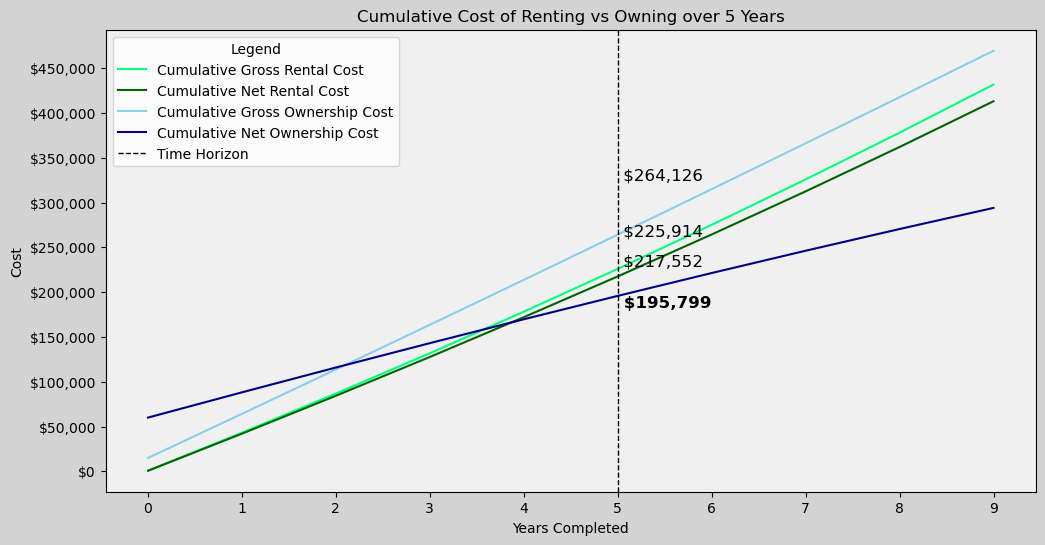

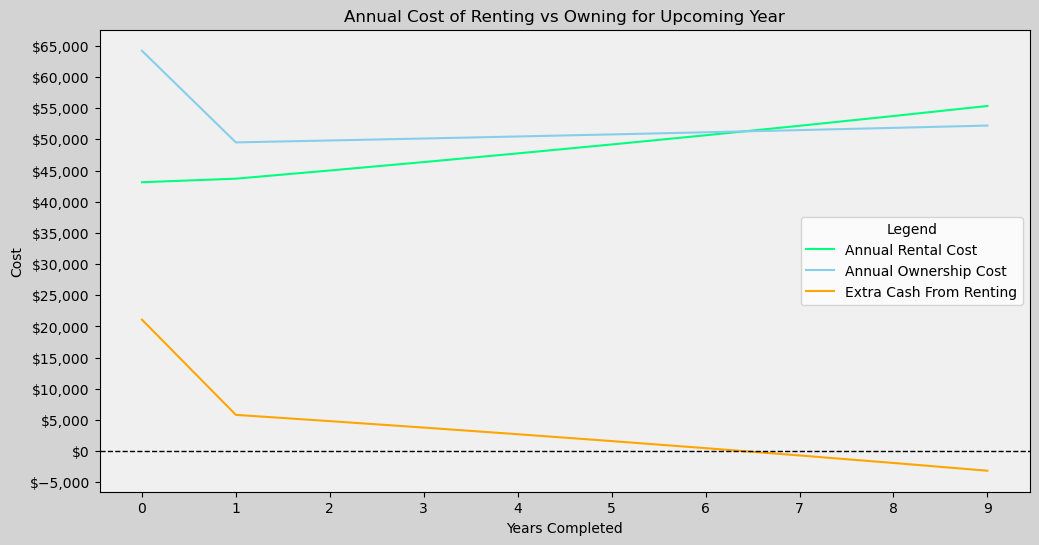

In [287]:
# ohh pretty colors!
color_map = {
    'Cumulative Gross Rental Cost': '#00FF7F',
    'Cumulative Net Rental Cost': '#006400',
    'Cumulative Gross Ownership Cost': '#87CEEB',
    'Cumulative Net Ownership Cost': '#000080',
    'Annual Rental Cost': '#00FF7F',
    'Annual Ownership Cost': '#87CEEB',
    'Extra Cash From Renting': '#FFA500',
    'Cumulative Delta': '#FFE500',
    'Cumulative Invested Returns': '#FF4500'
}


# plot cumulative costs
plt.figure(figsize=(12, 6))
for cost in cum_df.columns:
    plt.plot(cum_df.index, cum_df[cost], label=cost, color = color_map[cost])

plt.axvline(x = time_horizon, color='black', linestyle='--', linewidth=1, label='Time Horizon')
plot_points = sorted([gr_rent, net_rent, gr_own, net_own], reverse=False)
y_offset = 2500 * ub
for i, plpt in enumerate(plot_points):
    fontweight = 'bold' if i == 0 else 'normal'
    plt.text(time_horizon, plpt + i * y_offset, f' ${plpt:,.0f}', 
             ha = 'left', va = 'top', color = 'black', fontsize = 12, fontweight = fontweight) 

plt.xlabel('Years Completed') 
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))

plt.ylabel('Cost')
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(100000 if time_horizon > 5 else 50000))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.legend(title='Legend')
plt.title(f'Cumulative Cost of Renting vs Owning over {time_horizon} Years')
plt.gca().set_facecolor('#f0f0f0') 
plt.gcf().set_facecolor('#d3d3d3')  
plt.show()


# plot annual costs
plt.figure(figsize=(12, 6))
for cost in ann_df.columns:
    if 'Cumulative' not in cost:
        plt.plot(ann_df.index, ann_df[cost], label=cost, color = color_map[cost])
plt.axhline(y = 0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Years Completed') 
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))

plt.ylabel('Cost')
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(5000))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.legend(title='Legend')
plt.title(f'Annual Cost of Renting vs Owning for Upcoming Year')
plt.gca().set_facecolor('#f0f0f0') 
plt.gcf().set_facecolor('#d3d3d3')  
plt.show()